In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pylab as plt
import cvxpy as cp
import pandas as pd
from os.path import join
from scipy.spatial.distance import cdist
from scipy.sparse import csgraph
from scipy.stats import skew, kurtosis
from itertools import product
from sklearn.model_selection import KFold
from matplotlib.animation import FuncAnimation
from nilearn import masking
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map, view_img
import os, sys
from config import Config
from pathlib import Path


def clear_console():
    if os.name == "nt":
        os.system("cls")                     # Windows
    else:
        # Try tput (nicer), fall back to ANSI reset
        os.system("tput reset 2>/dev/null || printf '\033c'")


def find_active_voxels(glm_results, run, R2_thr=2.0, alpha=0.05, t_thr=None,
                       brain_mask=None, cluster_k=None):
    """
    Select active voxels by conjunction of:
      - significance of t-statistics (FDR q=alpha across voxels; or |t|>t_thr if provided)
      - GLMsingle R^2 (percent variance explained) > R2_thr (in PERCENT)
    Optional: restrict to brain_mask and drop clusters smaller than cluster_k voxels.

    Args:
        glm_results: dict from GLMsingle with keys 'betasmd' (X,Y,Z,T) and 'R2run' (X,Y,Z,run)
        run: 1 or 2 (selects R2run[:,:,:,0] or R2run[:,:,:,1] and the matching betas subset)
        R2_thr: float, percent variance explained threshold (e.g., 0 for lenient, 2–5 typical)
        alpha: FDR rate (ignored if t_thr is not None)
        t_thr: absolute t threshold; if None, uses FDR (recommended)
        brain_mask: optional boolean (X,Y,Z)
        cluster_k: optional int, minimum cluster size (voxels); requires scipy.ndimage if set

    Returns:
        betasmd, mask_pos, mask_neg (boolean volumes)
    """
    # --- pick run-specific data ---
    if run == 1:
        betasmd = glm_results['betasmd'][:,:,:,0:90]
        R2 = glm_results['R2run'][:,:,:,0]  # in PERCENT
    else:
        betasmd = glm_results['betasmd'][:,:,:,90:]
        R2 = glm_results['R2run'][:,:,:,1]  # in PERCENT

    X, Y, Z, T = betasmd.shape
    V = X * Y * Z
    B = betasmd.reshape(V, T)

    # --- t-statistics over trials (robust to NaNs) ---
    n = np.sum(~np.isnan(B), axis=1)                 # valid trial count per voxel
    mu = np.nanmean(B, axis=1)
    sd = np.nanstd(B, axis=1, ddof=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        se = sd / np.sqrt(np.clip(n, 1, None))
        t = mu / se
    t[~np.isfinite(t)] = np.nan  # n<2, zero variance, etc.

    mu_vol = mu.reshape(X, Y, Z)
    t_vol  = t.reshape(X, Y, Z)

    # --- significance mask: FDR (default) or hard t-threshold ---
    if t_thr is None:
        # Two-sided p-values for Student t; fallback to normal if SciPy missing
        # try:
        from scipy.stats import t as student_t
        df_vol = np.maximum(n - 1, 1).reshape(X, Y, Z) #degree of freedom
        pvals = 2.0 * student_t.sf(np.abs(t_vol), df_vol)
        # except Exception:
        #     # Normal approximation fallback
        #     pvals = 2.0 * 0.5 * np.erfc(np.abs(t_vol) / np.sqrt(2.0))

        # Apply FDR on voxels we actually test
        valid = np.isfinite(pvals)
        if brain_mask is not None:
            if brain_mask.shape != (X, Y, Z):
                raise ValueError(f"brain_mask shape {brain_mask.shape} != data shape {(X,Y,Z)}")
            valid &= brain_mask

        p_vec = pvals[valid].ravel()
        m = p_vec.size
        if m == 0:
            mask_sig = np.zeros((X, Y, Z), dtype=bool)
        else:
            order = np.argsort(p_vec)
            ranked = p_vec[order]
            thresh = (np.arange(1, m + 1) / m) * alpha
            print(thresh)
            passing = ranked <= thresh
            mask_sig = np.zeros((X, Y, Z), dtype=bool)
            if np.any(passing):
                kmax = np.max(np.where(passing)[0])
                p_cut = ranked[kmax]
                tmp = np.zeros_like(p_vec, dtype=bool)
                tmp[:] = p_vec <= p_cut
                # map back
                mask_sig_flat = np.zeros(valid.sum(), dtype=bool)
                mask_sig_flat[:] = tmp
                mask_sig[valid] = mask_sig_flat
    else:
        # Hard threshold on |t|
        mask_sig = np.isfinite(t_vol) & (np.abs(t_vol) > float(t_thr))
        if brain_mask is not None:
            if brain_mask.shape != (X, Y, Z):
                raise ValueError(f"brain_mask shape {brain_mask.shape} != data shape {(X,Y,Z)}")
            mask_sig &= brain_mask

    # --- R^2 quality gate (percent) ---
    mask_R2 = np.isfinite(R2) & (R2 > float(R2_thr))
    if brain_mask is not None:
        mask_R2 &= brain_mask

    base = mask_sig & mask_R2

    # --- optional cluster-size pruning ---
    if cluster_k is not None and cluster_k > 1:
        try:
            from scipy.ndimage import label
            labeled, nlab = label(base)
            if nlab > 0:
                counts = np.bincount(labeled.ravel())
                keep = counts >= cluster_k
                keep[0] = False  # background
                base = keep[labeled]
        except Exception:
            print("Note: cluster_k specified but scipy.ndimage not available; skipping cluster filter.")

    mask_pos = base & (mu_vol > 0)
    mask_neg = base & (mu_vol < 0)

    # --- logging ---
    print(f"R^2 (percent) range: {np.nanmin(R2):.2f} .. {np.nanmax(R2):.2f}")
    if t_thr is None:
        print(f"Significance: FDR q={alpha}")
    else:
        print(f"Significance: |t| > {t_thr}")
    # print(f"R^2 threshold: > {R2_thr}%")
    if brain_mask is not None:
        print(f"Masked voxels considered: {brain_mask.sum()} / {V}")
    print(f"Active voxels: {int(base.sum())}  (pos: {int(mask_pos.sum())}, neg: {int(mask_neg.sum())})")

    return betasmd, mask_pos, mask_neg

def find_active_low_var_voxels(betasmd, mask_pos, mask_neg, sk_thr, kt_thr):
    mask_union = mask_pos | mask_neg
    beta_pos = betasmd[mask_union,:]
    beta_diff = np.diff(beta_pos, axis=1) #diff between consequence trial

    sk = skew(beta_diff, axis=1, bias=False)
    kt = kurtosis(beta_diff, axis=1, fisher=False, bias=False)
    mask_gaussian_like = (np.abs(sk) < sk_thr) & (np.abs(kt - 3) < kt_thr)

    selected_voxels = np.zeros(mask_pos.shape, dtype=bool)
    selected_voxels[mask_union] = mask_gaussian_like

    return selected_voxels, beta_diff

def calculate_matrices(betasmd, selected_voxels, anat_img, affine, BOLD_path_org, trial_indices, trial_len):
    ## L_task Vector (contains beta values for selected voxels)##
    num_total_trials = betasmd.shape[-1]
    if trial_indices is None:
        trial_indices = np.arange(num_total_trials)

    V1 = betasmd[selected_voxels.astype(bool), :][:, trial_indices]
    mean_V1 = np.mean(V1, axis=-1)
    L_task = np.divide(1., np.abs(mean_V1), out=np.zeros_like(mean_V1), where=mean_V1 != 0)
    # L_task = 1./np.abs(mean_V1)


    BOLD_data = nib.load(BOLD_path_org).get_fdata() #(90, 128, 85, 850)
    selected_BOLD_data = BOLD_data[selected_voxels.astype(bool), :]
    selected_BOLD_data_reshape = np.zeros((selected_BOLD_data.shape[0], num_total_trials, trial_len))
    start = 0
    for i in range(num_trials):
        selected_BOLD_data_reshape[:, i, :] = selected_BOLD_data[:, start:start+trial_len]
        start += trial_len
        if start == 270 or start == 560:
            start += 20

    print(selected_BOLD_data_reshape.shape)
    selected_BOLD_data_subset = selected_BOLD_data_reshape[:, trial_indices, :]
    print(selected_BOLD_data_subset.shape)

    ## L_var matrix (contains variance of selected voxels)##
    diff_mat = np.diff(selected_BOLD_data_subset, axis=1)
    diff_mat_flat = diff_mat.reshape(diff_mat.shape[0], -1)
    L_var = np.cov(diff_mat_flat, bias=False)
    L_var = (L_var + L_var.T) / 2 + 1e-6 * np.eye(L_var.shape[0])
    # C2 = diff_mat_flat @ diff_mat_flat.T
    # L_var = C2 / selected_BOLD_data_reshape.shape[1]


    ## L_smooth matrix (contains distance beyween selected voxels)##
    anat_img_shape = anat_img.shape
    coords = np.array(np.meshgrid(
        np.arange(anat_img_shape[0]),
        np.arange(anat_img_shape[1]),
        np.arange(anat_img_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T

    # Convert to world (scanner/MNI) coordinates
    world_coords = nib.affines.apply_affine(affine, coords)
    tmp = selected_voxels.astype(bool).reshape(-1)
    selected_world_coords = world_coords[tmp,:]
    D = cdist(selected_world_coords, selected_world_coords)
    sigma = np.median(D[D>0])
    W = np.exp(-D**2 / (2*sigma**2))      # similarity
    np.fill_diagonal(W, 0.0)
    L_smooth = csgraph.laplacian(W, normed=False)
    # L_smooth = csgraph.laplacian(D)

    return L_task, L_var, L_smooth, selected_BOLD_data_subset.reshape(selected_BOLD_data_subset.shape[0], -1)

def objective_func(w, L_task, L_var, L_smooth,
              alpha_var, alpha_smooth):
    """Value of the full loss on a validation set."""
    quad = (w.T @ np.diag(L_task) @ w
            + alpha_var   * (w.T @ L_var    @ w)
            + alpha_smooth * (w.T @ L_smooth @ w))
    # l1 = alpha_sparse * np.sum(np.abs(w))
    return quad

def optimize_voxel_weights(
    L_task: np.ndarray,
    L_var: np.ndarray,
    L_smooth: np.ndarray,
    alpha_var: float = 1.0,
    alpha_smooth: float = 0.1):
    
    L_total = np.diag(L_task) + alpha_var * L_var + alpha_smooth * L_smooth
    n = L_total.shape[0]
    L_total = 0.5*(L_total + L_total.T) + 1e-8*np.eye(n)
    w = cp.Variable(n, nonneg=True)
    constraints = [cp.sum(w) == 1]
    
    # objective = cp.Minimize(cp.quad_form(w, L_total) + alpha_sparse * cp.norm1(w))
    objective = cp.Minimize(cp.quad_form(w, L_total))
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.OSQP, verbose=True)
    return w.value

def calculate_weight(param_grid, betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, trial_len):
    kf = KFold(n_splits=2, shuffle=True, random_state=0)
    best_score = np.inf
    best_params = None
    num_trials = betasmd.shape[-1]

    for a_var, a_smooth in product(*param_grid.values()):
        fold_scores = []
        print(f"a_var: {a_var}, a_smooth: {a_smooth}")
        count = 1

        for train_idx, val_idx in kf.split(np.arange(num_trials)):
            clear_console()
            print(f"k-fold num: {count}")
            L_task_train, L_var_train, L_smooth_train, _ = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, train_idx, trial_len)
            w = optimize_voxel_weights(L_task_train, L_var_train, L_smooth_train, alpha_var=a_var, alpha_smooth=a_smooth)

            L_task_val, L_var_val, L_smooth_val, _ = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, val_idx, trial_len)

            fold_scores.append(objective_func(w, L_task_val, L_var_val, L_smooth_val, a_var, a_smooth))
            print(f"fold_scores: {fold_scores}")
            count += 1

        mean_score = np.mean(fold_scores)
        print(mean_score)
        if mean_score < best_score:
            best_score = mean_score
            best_params = (a_var, a_smooth)

    clear_console()
    print("Best parameters:", best_params, "with CV loss:", best_score)
    return best_params, best_score

def select_opt_weight(selected_BOLD_data, weights, selected_voxels, affine):
    y = selected_BOLD_data.T @ weights
    p95 = np.percentile(weights, 95)

    weight_volume = np.zeros(selected_voxels.shape, dtype=np.float32)
    weight_volume[selected_voxels] = weights  # put weights in their voxel positions

    mask = np.zeros(selected_voxels.shape, dtype=bool)
    # Keep only the top 5% strongest weights
    selected_weights = (weights >= p95)
    mask[selected_voxels] = selected_weights
    weight_volume[~mask] = 0

    masked_weights = np.where(weight_volume == 0, np.nan, weight_volume)
    weight_img = nib.Nifti1Image(masked_weights, affine=affine)
    
    return weight_img, masked_weights, y

# %% 
# cfg = config()
t_thr = 3
R2_thr = 1.5
sk_thr = 0.1 
kt_thr = 0.2
run = 2
ses = 1
sub = '04'
num_trials = 90
trial_len = 9

# param_grid = {
#     "alpha_var":   [0.5, 1.0, 10.0],
#     "alpha_smooth":[0.5, 0.1, 1.0],
#     "alpha_sparse":[0.001, 0.01, 0.1]}

param_grid = {
    "alpha_var":   [0.5, 1.0],
    "alpha_smooth":[0.5, 1.0]}

# Use the same subject/session across GLMsingle results, anatomy, and BOLD
glm_result_path = (
    f"/mnt/TeamShare/Data_Masterfile/Zahra-Thesis-Data/Master_Thesis_Files/GLM_single_results/"
    f"GLMOutputs2-sub{sub}-ses0{ses}/TYPED_FITHRF_GLMDENOISE_RR.npy"
)
anat_img = nib.load(f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain_2mm.nii.gz')
base_path = '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'
data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg_2mm.nii.gz'
BOLD_path_org = join(base_path, f'sub-pd0{sub}', f'ses-{ses}', 'func', data_name)

glm_results = np.load(glm_result_path, allow_pickle=True).item()

# Build a conservative brain mask from skull-stripped T1
brain_mask_img = masking.compute_brain_mask(anat_img)
brain_mask = brain_mask_img.get_fdata().astype(bool)

anat_img = nib.as_closest_canonical(anat_img)
func_img = nib.as_closest_canonical(nib.load(BOLD_path_org))
ornt_anat = nib.orientations.io_orientation(anat_img.affine)
ornt_func = nib.orientations.io_orientation(func_img.affine)
xform = nib.orientations.ornt_transform(ornt_func, ornt_anat)

# betasmd, mask_pos, mask_neg = find_active_voxels(glm_results, run, t_thr, R2_thr, brain_mask=brain_mask)
betasmd, mask_pos, mask_neg = find_active_voxels(glm_results, run=1, R2_thr=2.0, alpha=0.05)

pos_native = nib.orientations.apply_orientation(mask_pos, xform)
selected_voxels_img = new_img_like(anat_img, pos_native.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Positive Active Voxels Map', cut_coords=(0,0,0))
view = view_img(selected_voxels_img, bg_img=anat_img)  # shows sliders to move cuts
view

neg_native = nib.orientations.apply_orientation(mask_neg, xform)
selected_voxels_img = new_img_like(anat_img, neg_native.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Negative Active Voxels Map', cut_coords=(0,0,0))
view = view_img(selected_voxels_img, bg_img=anat_img)  # shows sliders to move cuts
view


active_low_var_voxels, beta_diff = find_active_low_var_voxels(betasmd, mask_pos, mask_neg, sk_thr, kt_thr)

anat_data = anat_img.get_fdata()
affine = anat_img.affine
selected_voxels = nib.Nifti1Image(active_low_var_voxels.astype(np.uint8), affine)
nib.save(selected_voxels, f'affine_selected_active_low_var_voxels_session{ses}_run{run}.nii.gz')
save_path = f"anat_with_overlay(active_low_var_voxels_session{ses}_run{run}).png"


pos_native = nib.orientations.apply_orientation(mask_pos, xform)
selected_voxels_img = new_img_like(anat_img, pos_native.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Positive Active Voxels Map', cut_coords=(0,0,0))
view = view_img(selected_voxels_img, bg_img=anat_img, cmap='Reds')  # shows sliders to move cuts
view
view.save_as_html(f"Positive_active_brain_view_sub{sub}_ses{ses}_run{run}.html")

neg_native = nib.orientations.apply_orientation(mask_neg, xform)
selected_voxels_img = new_img_like(anat_img, neg_native.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Positive Active Voxels Map', cut_coords=(0,0,0))
view = view_img(selected_voxels_img, bg_img=anat_img, cmap='Blues')  # shows sliders to move cuts
view
view.save_as_html(f"negative_active_brain_view_sub{sub}_ses{ses}_run{run}.html")

active_low_var_voxels_reor = nib.orientations.apply_orientation(active_low_var_voxels, xform)
selected_voxels_img = new_img_like(anat_img, active_low_var_voxels_reor.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Active Low-variable Voxels Map', cut_coords=(0,0,0))
view = view_img(selected_voxels_img, bg_img=anat_img, cmap='jet')  # shows sliders to move cuts
view.save_as_html(f"low_var_active_brain_view_sub{sub}_ses{ses}_run{run}.html")


best_params, best_score = calculate_weight(param_grid, betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, trial_len)

L_task, L_var, L_smooth, selected_BOLD_data = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, None, trial_len)
weights = optimize_voxel_weights(L_task, L_var, L_smooth, alpha_var=best_params[0], alpha_smooth=best_params[1])
weight_img, masked_weights, y = select_opt_weight(selected_BOLD_data, weights, active_low_var_voxels.astype(bool), affine)
print(y.shape)

np.save(f"best_params_session{ses}_run{run}.npy", best_params)
np.save(f"masked_weights_session{ses}_run{run}.npy", masked_weights)
np.save(f"all_weights_session{ses}_run{run}.nii", weight_img)
np.save(f"reconstructed_sig_session{ses}_run{run}.npy",y)


selected_voxels = nib.Nifti1Image(active_low_var_voxels.astype(np.uint8), affine)
ornt_func = nib.orientations.io_orientation(selected_voxels.affine)
xform = nib.orientations.ornt_transform(ornt_func, ornt_anat)

weights = np.load('/home/zkavian/thesis_code_git/Optim_fMRI/masked_weights_session1_run2.npy')
active_low_var_voxels_reor = nib.orientations.apply_orientation(weights*10000, xform)
selected_voxels_img = new_img_like(anat_img, active_low_var_voxels_reor.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Active Low-variable Voxels Weights Map', cut_coords=(0,0,0))
view = view_img(selected_voxels_img, bg_img=anat_img, cmap='jet')  # shows sliders to move cuts
view.save_as_html(f"low_var_active_brain_weights_view_session{ses}_run{run}.html")

FileNotFoundError: No such file or no access: '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd004/ses-1/anat/sub-pd004_ses-1_T1w_brain_2mm.nii.gz'

/tmp/ipykernel_70300/1455237274.py:43: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(B, axis=1)
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[1.36181154e-07 2.72362307e-07 4.08543461e-07 ... 4.99997276e-02
 4.99998638e-02 5.00000000e-02]
R^2 (percent) range: -7.60 .. 44.25
Significance: FDR q=0.05
Active voxels: 124599  (pos: 70341, neg: 54258)


/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_70300/1455237274.py:335: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  view = view_img(selected_voxels_img, bg_img=anat_img)  # shows sliders to move cuts
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_70300/1455237274.py:342: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  view = view_img(selected_vox

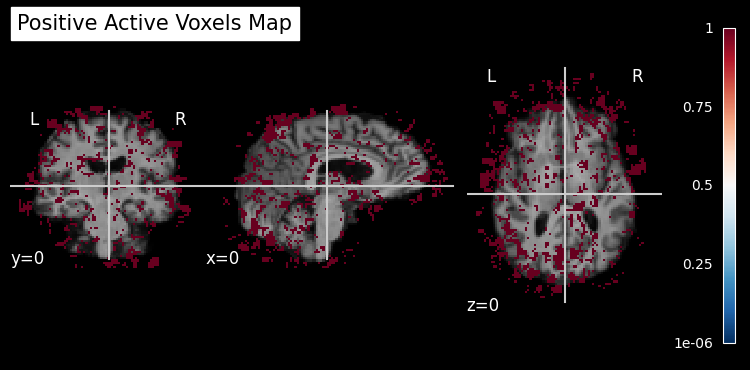

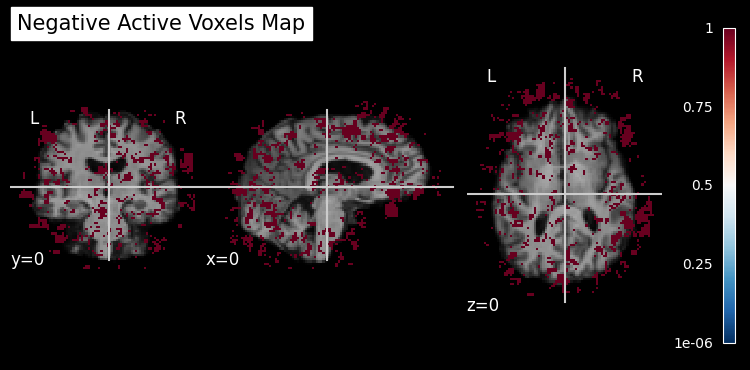

In [2]:
def clear_console():
    if os.name == "nt":
        os.system("cls")                     # Windows
    else:
        # Try tput (nicer), fall back to ANSI reset
        os.system("tput reset 2>/dev/null || printf '\033c'")


def find_active_voxels(glm_results, run, R2_thr=2.0, alpha=0.05, t_thr=None,
                       brain_mask=None, cluster_k=None):
    """
    Select active voxels by conjunction of:
      - significance of t-statistics (FDR q=alpha across voxels; or |t|>t_thr if provided)
      - GLMsingle R^2 (percent variance explained) > R2_thr (in PERCENT)
    Optional: restrict to brain_mask and drop clusters smaller than cluster_k voxels.

    Args:
        glm_results: dict from GLMsingle with keys 'betasmd' (X,Y,Z,T) and 'R2run' (X,Y,Z,run)
        run: 1 or 2 (selects R2run[:,:,:,0] or R2run[:,:,:,1] and the matching betas subset)
        R2_thr: float, percent variance explained threshold (e.g., 0 for lenient, 2–5 typical)
        alpha: FDR rate (ignored if t_thr is not None)
        t_thr: absolute t threshold; if None, uses FDR (recommended)
        brain_mask: optional boolean (X,Y,Z)
        cluster_k: optional int, minimum cluster size (voxels); requires scipy.ndimage if set

    Returns:
        betasmd, mask_pos, mask_neg (boolean volumes)
    """
    # --- pick run-specific data ---
    if run == 1:
        betasmd = glm_results['betasmd'][:,:,:,0:90]
        R2 = glm_results['R2run'][:,:,:,0]  # in PERCENT
    else:
        betasmd = glm_results['betasmd'][:,:,:,90:]
        R2 = glm_results['R2run'][:,:,:,1]  # in PERCENT

    X, Y, Z, T = betasmd.shape
    V = X * Y * Z
    B = betasmd.reshape(V, T)

    # --- t-statistics over trials (robust to NaNs) ---
    n = np.sum(~np.isnan(B), axis=1)                 # valid trial count per voxel
    mu = np.nanmean(B, axis=1)
    sd = np.nanstd(B, axis=1, ddof=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        se = sd / np.sqrt(np.clip(n, 1, None))
        t = mu / se
    t[~np.isfinite(t)] = np.nan  # n<2, zero variance, etc.

    mu_vol = mu.reshape(X, Y, Z)
    t_vol  = t.reshape(X, Y, Z)

    # --- significance mask: FDR (default) or hard t-threshold ---
    if t_thr is None:
        # Two-sided p-values for Student t; fallback to normal if SciPy missing
        # try:
        from scipy.stats import t as student_t
        df_vol = np.maximum(n - 1, 1).reshape(X, Y, Z)
        pvals = 2.0 * student_t.sf(np.abs(t_vol), df_vol)
        # except Exception:
        #     # Normal approximation fallback
        #     pvals = 2.0 * 0.5 * np.erfc(np.abs(t_vol) / np.sqrt(2.0))

        # Apply FDR on voxels we actually test
        valid = np.isfinite(pvals)
        if brain_mask is not None:
            if brain_mask.shape != (X, Y, Z):
                raise ValueError(f"brain_mask shape {brain_mask.shape} != data shape {(X,Y,Z)}")
            valid &= brain_mask

        p_vec = pvals[valid].ravel()
        m = p_vec.size
        if m == 0:
            mask_sig = np.zeros((X, Y, Z), dtype=bool)
        else:
            order = np.argsort(p_vec)
            ranked = p_vec[order]
            thresh = (np.arange(1, m + 1) / m) * alpha
            print(thresh)
            passing = ranked <= thresh
            mask_sig = np.zeros((X, Y, Z), dtype=bool)
            if np.any(passing):
                kmax = np.max(np.where(passing)[0])
                p_cut = ranked[kmax]
                tmp = np.zeros_like(p_vec, dtype=bool)
                tmp[:] = p_vec <= p_cut
                # map back
                mask_sig_flat = np.zeros(valid.sum(), dtype=bool)
                mask_sig_flat[:] = tmp
                mask_sig[valid] = mask_sig_flat
    else:
        # Hard threshold on |t|
        mask_sig = np.isfinite(t_vol) & (np.abs(t_vol) > float(t_thr))
        if brain_mask is not None:
            if brain_mask.shape != (X, Y, Z):
                raise ValueError(f"brain_mask shape {brain_mask.shape} != data shape {(X,Y,Z)}")
            mask_sig &= brain_mask

    # --- R^2 quality gate (percent) ---
    mask_R2 = np.isfinite(R2) & (R2 > float(R2_thr))
    if brain_mask is not None:
        mask_R2 &= brain_mask

    base = mask_sig & mask_R2

    # --- optional cluster-size pruning ---
    if cluster_k is not None and cluster_k > 1:
        try:
            from scipy.ndimage import label
            labeled, nlab = label(base)
            if nlab > 0:
                counts = np.bincount(labeled.ravel())
                keep = counts >= cluster_k
                keep[0] = False  # background
                base = keep[labeled]
        except Exception:
            print("Note: cluster_k specified but scipy.ndimage not available; skipping cluster filter.")

    mask_pos = base & (mu_vol > 0)
    mask_neg = base & (mu_vol < 0)

    # --- logging ---
    print(f"R^2 (percent) range: {np.nanmin(R2):.2f} .. {np.nanmax(R2):.2f}")
    if t_thr is None:
        print(f"Significance: FDR q={alpha}")
    else:
        print(f"Significance: |t| > {t_thr}")
    # print(f"R^2 threshold: > {R2_thr}%")
    if brain_mask is not None:
        print(f"Masked voxels considered: {brain_mask.sum()} / {V}")
    print(f"Active voxels: {int(base.sum())}  (pos: {int(mask_pos.sum())}, neg: {int(mask_neg.sum())})")

    return betasmd, mask_pos, mask_neg


def find_active_low_var_voxels(betasmd, mask_pos, mask_neg, sk_thr, kt_thr):
    mask_union = mask_pos | mask_neg
    beta_pos = betasmd[mask_union,:]
    beta_diff = np.diff(beta_pos, axis=1) #diff between consequence trial

    sk = skew(beta_diff, axis=1, bias=False)
    kt = kurtosis(beta_diff, axis=1, fisher=False, bias=False)
    mask_gaussian_like = (np.abs(sk) < sk_thr) & (np.abs(kt - 3) < kt_thr)

    selected_voxels = np.zeros(mask_pos.shape, dtype=bool)
    selected_voxels[mask_union] = mask_gaussian_like

    return selected_voxels, beta_diff

def calculate_matrices(betasmd, selected_voxels, anat_img, affine, BOLD_path_org, trial_indices, trial_len):
    ## L_task Vector (contains beta values for selected voxels)##
    num_total_trials = betasmd.shape[-1]
    if trial_indices is None:
        trial_indices = np.arange(num_total_trials)

    V1 = betasmd[selected_voxels.astype(bool), :][:, trial_indices]
    mean_V1 = np.mean(V1, axis=-1)
    L_task = np.divide(1., np.abs(mean_V1), out=np.zeros_like(mean_V1), where=mean_V1 != 0)
    # L_task = 1./np.abs(mean_V1)


    BOLD_data = nib.load(BOLD_path_org).get_fdata() #(90, 128, 85, 850)
    selected_BOLD_data = BOLD_data[selected_voxels.astype(bool), :]
    selected_BOLD_data_reshape = np.zeros((selected_BOLD_data.shape[0], num_total_trials, trial_len))
    start = 0
    for i in range(num_trials):
        selected_BOLD_data_reshape[:, i, :] = selected_BOLD_data[:, start:start+trial_len]
        start += trial_len
        if start == 270 or start == 560:
            start += 20

    print(selected_BOLD_data_reshape.shape)
    selected_BOLD_data_subset = selected_BOLD_data_reshape[:, trial_indices, :]
    print(selected_BOLD_data_subset.shape)

    ## L_var matrix (contains variance of selected voxels)##
    diff_mat = np.diff(selected_BOLD_data_subset, axis=1)
    diff_mat_flat = diff_mat.reshape(diff_mat.shape[0], -1)
    L_var = np.cov(diff_mat_flat, bias=False)
    L_var = (L_var + L_var.T) / 2 + 1e-6 * np.eye(L_var.shape[0])
    # C2 = diff_mat_flat @ diff_mat_flat.T
    # L_var = C2 / selected_BOLD_data_reshape.shape[1]


    ## L_smooth matrix (contains distance beyween selected voxels)##
    anat_img_shape = anat_img.shape
    coords = np.array(np.meshgrid(
        np.arange(anat_img_shape[0]),
        np.arange(anat_img_shape[1]),
        np.arange(anat_img_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T

    # Convert to world (scanner/MNI) coordinates
    world_coords = nib.affines.apply_affine(affine, coords)
    tmp = selected_voxels.astype(bool).reshape(-1)
    selected_world_coords = world_coords[tmp,:]
    D = cdist(selected_world_coords, selected_world_coords)
    sigma = np.median(D[D>0])
    W = np.exp(-D**2 / (2*sigma**2))      # similarity
    np.fill_diagonal(W, 0.0)
    L_smooth = csgraph.laplacian(W, normed=False)
    # L_smooth = csgraph.laplacian(D)

    return L_task, L_var, L_smooth, selected_BOLD_data_subset.reshape(selected_BOLD_data_subset.shape[0], -1)

def objective_func(w, L_task, L_var, L_smooth,
              alpha_var, alpha_smooth):
    """Value of the full loss on a validation set."""
    quad = (w.T @ np.diag(L_task) @ w
            + alpha_var   * (w.T @ L_var    @ w)
            + alpha_smooth * (w.T @ L_smooth @ w))
    # l1 = alpha_sparse * np.sum(np.abs(w))
    return quad

def optimize_voxel_weights(
    L_task: np.ndarray,
    L_var: np.ndarray,
    L_smooth: np.ndarray,
    alpha_var: float = 1.0,
    alpha_smooth: float = 0.1):
    
    L_total = np.diag(L_task) + alpha_var * L_var + alpha_smooth * L_smooth
    n = L_total.shape[0]
    L_total = 0.5*(L_total + L_total.T) + 1e-8*np.eye(n)
    w = cp.Variable(n, nonneg=True)
    constraints = [cp.sum(w) == 1]
    
    # objective = cp.Minimize(cp.quad_form(w, L_total) + alpha_sparse * cp.norm1(w))
    objective = cp.Minimize(cp.quad_form(w, L_total))
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.OSQP, verbose=True)
    return w.value

def calculate_weight(param_grid, betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, trial_len):
    kf = KFold(n_splits=2, shuffle=True, random_state=0)
    best_score = np.inf
    best_params = None
    num_trials = betasmd.shape[-1]

    for a_var, a_smooth in product(*param_grid.values()):
        fold_scores = []
        print(f"a_var: {a_var}, a_smooth: {a_smooth}")
        count = 1

        for train_idx, val_idx in kf.split(np.arange(num_trials)):
            clear_console()
            print(f"k-fold num: {count}")
            L_task_train, L_var_train, L_smooth_train, _ = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, train_idx, trial_len)
            w = optimize_voxel_weights(L_task_train, L_var_train, L_smooth_train, alpha_var=a_var, alpha_smooth=a_smooth)

            L_task_val, L_var_val, L_smooth_val, _ = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, val_idx, trial_len)

            fold_scores.append(objective_func(w, L_task_val, L_var_val, L_smooth_val, a_var, a_smooth))
            print(f"fold_scores: {fold_scores}")
            count += 1

        mean_score = np.mean(fold_scores)
        print(mean_score)
        if mean_score < best_score:
            best_score = mean_score
            best_params = (a_var, a_smooth)

    clear_console()
    print("Best parameters:", best_params, "with CV loss:", best_score)
    return best_params, best_score

def select_opt_weight(selected_BOLD_data, weights, selected_voxels, affine):
    y = selected_BOLD_data.T @ weights
    p95 = np.percentile(weights, 95)

    weight_volume = np.zeros(selected_voxels.shape, dtype=np.float32)
    weight_volume[selected_voxels] = weights  # put weights in their voxel positions

    mask = np.zeros(selected_voxels.shape, dtype=bool)
    # Keep only the top 5% strongest weights
    selected_weights = (weights >= p95)
    mask[selected_voxels] = selected_weights
    weight_volume[~mask] = 0

    masked_weights = np.where(weight_volume == 0, np.nan, weight_volume)
    weight_img = nib.Nifti1Image(masked_weights, affine=affine)
    
    return weight_img, masked_weights, y

# %% 
t_thr = 3
R2_thr = 1.5
sk_thr = 0.1 
kt_thr = 0.2
run = 2
ses = 1
sub = '04'
num_trials = 90
trial_len = 9

# param_grid = {
#     "alpha_var":   [0.5, 1.0, 10.0],
#     "alpha_smooth":[0.5, 0.1, 1.0],
#     "alpha_sparse":[0.001, 0.01, 0.1]}

param_grid = {
    "alpha_var":   [0.5, 1.0],
    "alpha_smooth":[0.5, 1.0]}

# Use the same subject/session across GLMsingle results, anatomy, and BOLD
glm_result_path = (
    f"/mnt/TeamShare/Data_Masterfile/Zahra-Thesis-Data/Master_Thesis_Files/GLM_single_results/"
    f"GLMOutputs2-sub{sub}-ses0{ses}/TYPED_FITHRF_GLMDENOISE_RR.npy"
)
anat_img = nib.load(f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain_2mm.nii.gz')
base_path = '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'
data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg_2mm.nii.gz'
BOLD_path_org = join(base_path, f'sub-pd0{sub}', f'ses-{ses}', 'func', data_name)

glm_results = np.load(glm_result_path, allow_pickle=True).item()

# Build a conservative brain mask from skull-stripped T1
brain_mask_img = masking.compute_brain_mask(anat_img)
brain_mask = brain_mask_img.get_fdata().astype(bool)

anat_img = nib.as_closest_canonical(anat_img)
func_img = nib.as_closest_canonical(nib.load(BOLD_path_org))
ornt_anat = nib.orientations.io_orientation(anat_img.affine)
ornt_func = nib.orientations.io_orientation(func_img.affine)
xform = nib.orientations.ornt_transform(ornt_func, ornt_anat)

# betasmd, mask_pos, mask_neg = find_active_voxels(glm_results, run, t_thr, R2_thr, brain_mask=brain_mask)
betasmd, mask_pos, mask_neg = find_active_voxels(glm_results, run=1, R2_thr=2.0, alpha=0.05)

pos_native = nib.orientations.apply_orientation(mask_pos, xform)
selected_voxels_img = new_img_like(anat_img, pos_native.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Positive Active Voxels Map', cut_coords=(0,0,0))
view = view_img(selected_voxels_img, bg_img=anat_img)  # shows sliders to move cuts
view

neg_native = nib.orientations.apply_orientation(mask_neg, xform)
selected_voxels_img = new_img_like(anat_img, neg_native.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Negative Active Voxels Map', cut_coords=(0,0,0))
view = view_img(selected_voxels_img, bg_img=anat_img)  # shows sliders to move cuts
view


active_low_var_voxels, beta_diff = find_active_low_var_voxels(betasmd, mask_pos, mask_neg, sk_thr, kt_thr)

anat_data = anat_img.get_fdata()
affine = anat_img.affine
selected_voxels = nib.Nifti1Image(active_low_var_voxels.astype(np.uint8), affine)
nib.save(selected_voxels, f'affine_selected_active_low_var_voxels_session{ses}_run{run}.nii.gz')
save_path = f"anat_with_overlay(active_low_var_voxels_session{ses}_run{run}).png"

In [13]:
glm_results['betasmd'].shape

(90, 128, 85, 180)

In [21]:
90*128*85

979200

-10129.226 26931.227


(-100.0, 100.0)

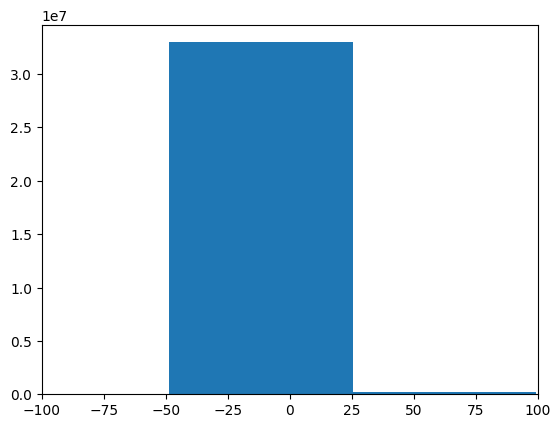

In [28]:
tmp = glm_results['betasmd'][:,:,:,:90]
print(np.nanmin(tmp), np.nanmax(tmp))
plt.figure()
plt.hist(tmp[~np.isnan(tmp)], bins=500)
plt.xlim(-100, 100)

In [34]:
np.nanmean(tmp)

tmp2 = tmp[np.abs(tmp)>= 25]
tmp3 = tmp.reshape(-1)
len(tmp2) / len(tmp3) *100



0.490721450617284

/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_70300/3849983867.py:5: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  view = view_img(selected_voxels_img, bg_img=anat_img, cmap='Reds')  # shows sliders to move cuts
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_70300/3849983867.py:13: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  view = view_img(se

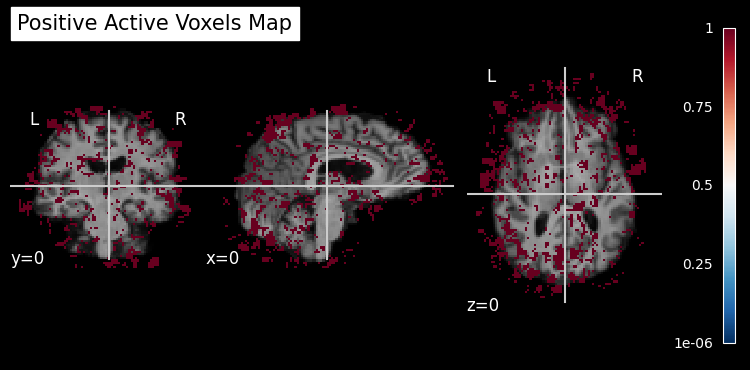

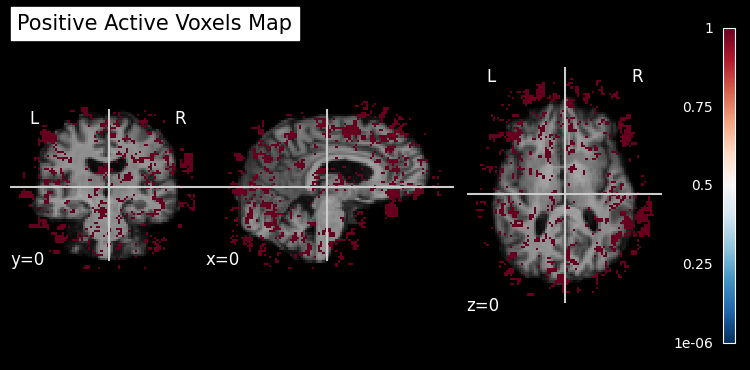

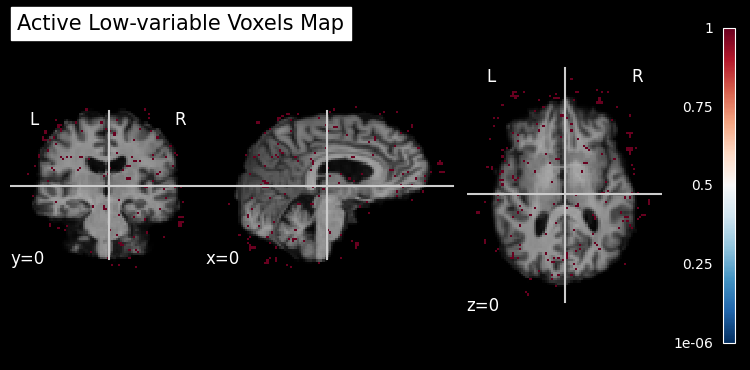

In [3]:
pos_native = nib.orientations.apply_orientation(mask_pos, xform)
selected_voxels_img = new_img_like(anat_img, pos_native.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Positive Active Voxels Map', cut_coords=(0,0,0))
view = view_img(selected_voxels_img, bg_img=anat_img, cmap='Reds')  # shows sliders to move cuts
view
view.save_as_html(f"Positive_active_brain_view_sub{sub}_ses{ses}_run{run}.html")

neg_native = nib.orientations.apply_orientation(mask_neg, xform)
selected_voxels_img = new_img_like(anat_img, neg_native.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Positive Active Voxels Map', cut_coords=(0,0,0))
view = view_img(selected_voxels_img, bg_img=anat_img, cmap='Blues')  # shows sliders to move cuts
view
view.save_as_html(f"negative_active_brain_view_sub{sub}_ses{ses}_run{run}.html")

active_low_var_voxels_reor = nib.orientations.apply_orientation(active_low_var_voxels, xform)
selected_voxels_img = new_img_like(anat_img, active_low_var_voxels_reor.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Active Low-variable Voxels Map', cut_coords=(0,0,0))
view = view_img(selected_voxels_img, bg_img=anat_img, cmap='jet')  # shows sliders to move cuts
view.save_as_html(f"low_var_active_brain_view_sub{sub}_ses{ses}_run{run}.html")


/tmp/ipykernel_70300/3786233454.py:7: RuntimeWarning: invalid value encountered in cast
  selected_voxels_img = new_img_like(anat_img, active_low_var_voxels_reor.astype(np.uint8))
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


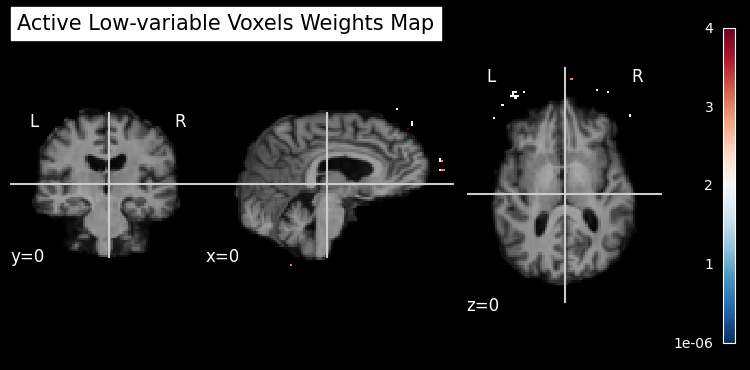

In [ ]:
best_params, best_score = calculate_weight(param_grid, betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, trial_len)

L_task, L_var, L_smooth, selected_BOLD_data = calculate_matrices(betasmd, active_low_var_voxels, anat_img, affine, BOLD_path_org, None, trial_len)
weights = optimize_voxel_weights(L_task, L_var, L_smooth, alpha_var=best_params[0], alpha_smooth=best_params[1])
weight_img, masked_weights, y = select_opt_weight(selected_BOLD_data, weights, active_low_var_voxels.astype(bool), affine)
print(y.shape)

np.save(f"best_params_session{ses}_run{run}.npy", best_params)
np.save(f"masked_weights_session{ses}_run{run}.npy", masked_weights)
np.save(f"all_weights_session{ses}_run{run}.nii", weight_img)
np.save(f"reconstructed_sig_session{ses}_run{run}.npy",y)


selected_voxels = nib.Nifti1Image(active_low_var_voxels.astype(np.uint8), affine)
ornt_func = nib.orientations.io_orientation(selected_voxels.affine)
xform = nib.orientations.ornt_transform(ornt_func, ornt_anat)

weights = np.load('/home/zkavian/thesis_code_git/Optim_fMRI/masked_weights_session1_run2.npy')
active_low_var_voxels_reor = nib.orientations.apply_orientation(weights*10000, xform)
selected_voxels_img = new_img_like(anat_img, active_low_var_voxels_reor.astype(np.uint8))
plot_stat_map(selected_voxels_img, bg_img=anat_img, display_mode='ortho',
              resampling_interpolation='nearest', title='Active Low-variable Voxels Weights Map', cut_coords=(0,0,0))
view = view_img(selected_voxels_img, bg_img=anat_img, cmap='jet')  # shows sliders to move cuts
view.save_as_html(f"low_var_active_brain_weights_view_session{ses}_run{run}.html")